In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold, train_test_split
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [100]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [101]:
train.dtypes

rent_approval_date      object
town                    object
block                   object
street_name             object
flat_type               object
flat_model              object
floor_area_sqm         float64
furnished               object
lease_commence_date      int64
latitude               float64
longitude              float64
elevation              float64
subzone                 object
planning_area           object
region                  object
monthly_rent             int64
dtype: object

# Exploratory Data Analysis 

**Duplicates**

In [102]:
train[train.duplicated(keep=False)].shape

(544, 16)

**Missing Values**

In [103]:
train['elevation'].value_counts()

elevation
0.0    60000
Name: count, dtype: int64

**Irrelevant Attributes**

In [104]:
train['furnished'].value_counts()

furnished
yes    60000
Name: count, dtype: int64

**Data Cleaning**

In [105]:
train['flat_type'].value_counts()

flat_type
4-room       12840
3-room       11125
4 room        9049
5-room        8524
3 room        7772
5 room        6235
executive     3528
2-room         617
2 room         310
Name: count, dtype: int64

In [106]:
train['street_name'].value_counts()

street_name
ang mo kio avenue 3      480
yishun ring road         473
ang mo kio avenue 10     463
bedok reservoir road     385
Ang Mo Kio Avenue 3      351
                        ... 
Kreta Ayer Road            1
Marine Parade Central      1
seng poh road              1
Jurong West Street 51      1
Zion Road                  1
Name: count, Length: 1083, dtype: int64

**Outliers**

Text(0.5, 0, 'Monthly Rent')

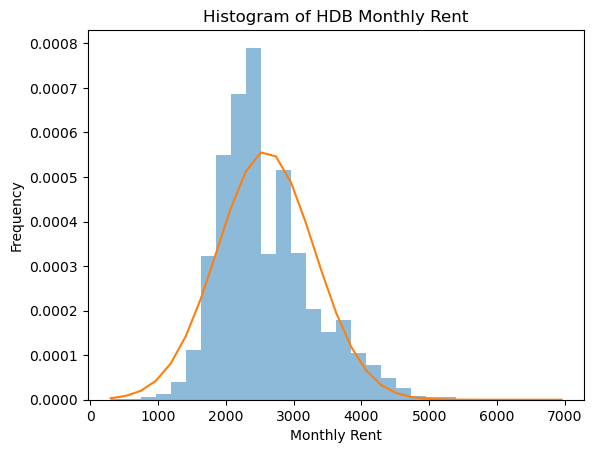

In [107]:
_, bins, _ = plt.hist(train['monthly_rent'], 30, density=1, alpha=0.5)

mu, sigma = scipy.stats.norm.fit(train['monthly_rent'])
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
plt.plot(bins, best_fit_line)


plt.title('Histogram of HDB Monthly Rent')
plt.ylabel('Frequency')
plt.xlabel('Monthly Rent')

<Axes: title={'center': 'monthly_rent'}, xlabel='flat_type'>

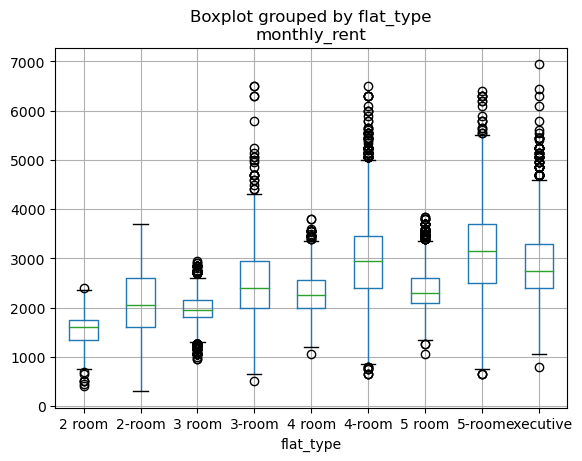

In [108]:
train.boxplot(by = 'flat_type', column = 'monthly_rent')

**Others**

## Data Transformation

In [109]:
mrt_existing = pd.read_csv('sg-mrt-existing-stations.csv')
mrt_planned = pd.read_csv('sg-mrt-planned-stations.csv')
primary_schools = pd.read_csv('sg-primary-schools.csv')
shopping_malls = pd.read_csv('sg-shopping-malls.csv')

**General**

In [110]:
def remove_duplicates(df):
    return df.drop_duplicates()

def deal_missing_value(df):
    return df.drop(columns=['elevation'])

def remove_irrelevant_attributes(df):
    return df.drop(columns=['furnished'])

def standardize_attribute_value(df):
    df['flat_type'] = df['flat_type'].str.replace('-', ' ').str.strip()
    df['street_name'] = df['street_name'].str.lower()
    return df

def create_attributes(df):
    # year and month from rent_approval_date
    df[['rent_approval_year', 'rent_approval_month']] = df['rent_approval_date'].str.split('-', expand=True)
    df['rent_approval_year'] = df['rent_approval_year'].astype(int)
    df['rent_approval_month'] = df['rent_approval_month'].astype(int)

    # house age from subtract rent_approval_year and lease_commence_date
    df['house_age'] = df['rent_approval_year'] - df['lease_commence_date']
    return df

def remove_train_outliers(df):
    # monthly rent <= 1.5IQR
    rent_distribution = df['monthly_rent'].describe()
    IQR = rent_distribution['75%'] - rent_distribution['25%']
    lower_bound = rent_distribution['25%'] - 1.5 * IQR
    return df[df['monthly_rent'] >= lower_bound]

**Auxillary Data**

In [111]:
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in kilometers between two points
    on the earth (specified in decimal degrees).
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return c * r

def count_within_radius(reference_df, target_df, radius=1.0):
    """
    Count the number of points in target_df within the specified radius
    from each point in reference_df.
    """
    count_list = []
    for _, row in reference_df.iterrows():
        distances = haversine(row['latitude'], row['longitude'], target_df['latitude'].values, target_df['longitude'].values)
        count = np.sum(distances < radius)
        count_list.append(count)
    return count_list

def get_facilities(df):
    df['mrt_existing_count_1km'] = count_within_radius(df, mrt_existing)
    df['mrt_planned_count_1km'] = count_within_radius(df, mrt_planned)
    df['primary_schools_count_1km'] = count_within_radius(df, primary_schools)
    df['shopping_malls_count_1km'] = count_within_radius(df, shopping_malls)
    return df

def get_nearest_mrt(df):
    train_coords = df[['latitude', 'longitude']].to_numpy()
    mrt_coords = mrt_existing[['latitude', 'longitude']].to_numpy()
    train_distances = cdist(train_coords, mrt_coords)
    train_min_indices = train_distances.argmin(axis=1)
    df['nearest_mrt_station'] = mrt_existing.iloc[train_min_indices]['name'].values
    df['distance_to_nearest_mrt'] = train_distances.min(axis=1)

    return df

def get_information_mrt(df):
    mrt_existing = mrt_existing.drop_duplicates(subset='name')
    df = df.merge(mrt_existing[['name', 'code']], left_on='nearest_mrt_station', right_on='name', how='left')
    df['line'] = df['code'].str[:2]
    df['mrt_no'] = df['code'].str[2:]
    df.drop(columns=['code', 'name'], inplace=True)
    return df

**Utility Functions for Modelling**

In [112]:
def preprocess_data(df):
    df = remove_duplicates(df)
    df = deal_missing_value(df)
    df = remove_irrelevant_attributes(df)
    df = standardize_attribute_value(df)
    df = create_attributes(df)
    df = remove_train_outliers(df)
    df = get_facilities(df)
    df = get_nearest_mrt(df)

    return df

In [113]:
def preprocess_test_data(df):
    df = deal_missing_value(df)
    df = standardize_attribute_value(df)
    df = remove_irrelevant_attributes(df)
    df = create_attributes(df)
    df = get_facilities(df)
    df = get_nearest_mrt(df)
    return df

In [114]:
def calculate_RMSE(yhat, y):
    return np.sqrt(sum((yhat -y)**2)/len(yhat))

# Linear Regression

**Feature Selection**

In [115]:
data = pd.read_csv('train.csv')
data = preprocess_data(data)

In [116]:
x = data.drop(columns='monthly_rent')
mrt_num_features = ['rent_approval_year', 'rent_approval_month', 'floor_area_sqm','latitude', 'longitude', 'house_age', 'mrt_existing_count_1km','mrt_planned_count_1km']
primary_schools_num_features = ['rent_approval_year', 'rent_approval_month', 'floor_area_sqm','latitude', 'longitude', 'house_age', 'primary_schools_count_1km']
shopping_malls_num_features = ['rent_approval_year', 'rent_approval_month', 'floor_area_sqm','latitude', 'longitude', 'house_age', 'shopping_malls_count_1km']

num_features = ['rent_approval_year', 'rent_approval_month', 'floor_area_sqm','latitude', 'longitude', 'house_age', 'mrt_existing_count_1km', 'distance_to_nearest_mrt']

cat_features = ['flat_type', 'town']

x_cat = x[cat_features]
encoder = preprocessing.OneHotEncoder(sparse_output=False)
x_cat_transformed = encoder.fit_transform(x_cat)

x_num  = x[num_features].to_numpy()
x_concat = np.concatenate((x_num, x_cat_transformed), axis=1)

y = data['monthly_rent']
y = y.to_numpy()

**Modelling**

In [118]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for train, test in skf.split(x_concat, y):
    train_X = x_concat[train]
    train_y = y[train]

    test_X = x_concat[test]
    test_y = y[test]

    ln = LinearRegression()
    ln.fit(train_X, train_y)
    predicted_y = ln.predict(test_X)
    rmse = calculate_RMSE(predicted_y, test_y)
    print(rmse)

/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


505.65987272929164
503.34070572433166
497.5254511575954
499.3020704210529
506.66423416106335


**for Kaggle**

In [119]:
ln = LinearRegression()
ln.fit(x_concat, y)

LinearRegression()

In [120]:
test = pd.read_csv('test.csv')
processed_test = preprocess_test_data(test)

In [121]:
test_x_cat = processed_test[cat_features]
encoder = preprocessing.OneHotEncoder(sparse_output=False)
test_x_cat_transformed = encoder.fit_transform(test_x_cat)

test_x_num  = processed_test[num_features].to_numpy()
test_x_concat = np.concatenate((test_x_num, test_x_cat_transformed), axis=1)

In [122]:
prediction = ln.predict(test_x_concat)

In [123]:
predictions_df = pd.DataFrame({
    'Id': np.arange(len(prediction)),
    'Predicted': prediction
})
# Save the DataFrame to a CSV file
predictions_df.to_csv('prediction_ln.csv', index=False)

RMSE_cv = 499.05528

# KNN

**utility functions for KNN**

In [124]:
def standardize_mrt_station(df):
    df['nearest_mrt_station'] = df['nearest_mrt_station'].str.replace('-', ' ').str.lower()
    return df

In [125]:
def knn_preprocess_data(df):
    df = remove_duplicates(df)
    df = deal_missing_value(df)
    df = remove_irrelevant_attributes(df)
    df = standardize_attribute_value(df)
    df = create_attributes(df)
    df = remove_train_outliers(df)
    df = get_facilities(df)
    df = get_nearest_mrt(df)
    df = standardize_mrt_station(df)
    return df

def knn_preprocess_test_data(df):
    # df = remove_duplicates(df)
    df = deal_missing_value(df)
    df = remove_irrelevant_attributes(df)
    df = standardize_attribute_value(df)
    df = create_attributes(df)
    df = get_facilities(df)
    df = get_nearest_mrt(df)
    df = standardize_mrt_station(df)
    return df

**Feature Selection**

In [126]:
data = pd.read_csv('train.csv')
data = knn_preprocess_data(data)

In [127]:
x = data.drop(columns='monthly_rent')
# baseline: N = 10, RMSE around 520
# num_features = ['floor_area_sqm', 'latitude', 'longitude', 'rent_approval_year', 'rent_approval_month', 'house_age', 'mrt_existing_count_1km', 'mrt_planned_count_1km', 'primary_schools_count_1km', 'shopping_malls_count_1km', 'distance_to_nearest_mrt']
# cat_features = ['town', 'flat_type', 'flat_model', 'nearest_mrt_station']

# with the following features, N = 30, KNN has best performance, with RMSE ~ 498
num_features = ['floor_area_sqm',   'rent_approval_year', 'rent_approval_month', 'house_age', 'mrt_existing_count_1km', 'distance_to_nearest_mrt']
cat_features = ['town', 'flat_type']

x_cat = x[cat_features]
encoder = preprocessing.OneHotEncoder(sparse_output=False)
x_cat_transformed = encoder.fit_transform(x_cat)

x_num  = x[num_features].to_numpy()
x_concat = np.concatenate((x_num, x_cat_transformed), axis=1)

y = data['monthly_rent']
y = y.to_numpy()

**Modelling**

In [128]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
N = 30
# knn model
n_list = []
rmse_list = []
total_rmse = 0
for train, test in skf.split(x_concat, y):
    train_X = x_concat[train]
    scalar = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(train_X)
    # scalar = preprocessing.StandardScaler().fit(train_X)
    train_y = y[train]

    test_X = x_concat[test]
    test_y = y[test]

    neigh = KNeighborsRegressor(n_neighbors=N)
    neigh.fit(scalar.transform(train_X), train_y)
    predicted_y = neigh.predict(scalar.transform(test_X))
    rmse = calculate_RMSE(predicted_y, test_y)
    print(rmse)


/usr/local/anaconda3/envs/CS5340_project/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


502.0355022434612
499.79869740098553
492.9434422745814
494.62648685383925
504.95040852588835


**Model Diagnosis**

In [136]:
# for a random split of 20:80 for testing and training data and visualization

from sklearn.model_selection import train_test_split

# Let's assume 'X' is your feature matrix and 'y' is the target vector
# X = ... (your feature matrix)
# y = ... (your target vector)

N = 30

X_train, X_test, y_train, y_test = train_test_split(x_concat, y, test_size=0.20, random_state=42)

scalar = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(X_train)
# scalar = preprocessing.StandardScaler().fit(train_X)


neigh = KNeighborsRegressor(n_neighbors=N)
neigh.fit(scalar.transform(X_train), y_train)
predicted_y = neigh.predict(scalar.transform(X_test))
rmse = calculate_RMSE(predicted_y, y_test)
print(rmse)

501.19104147177705


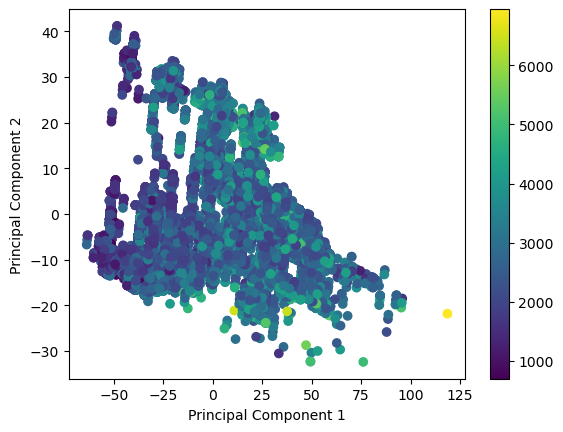

In [137]:
# Let's assume 'X' is your features matrix and 'y' your target vector
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

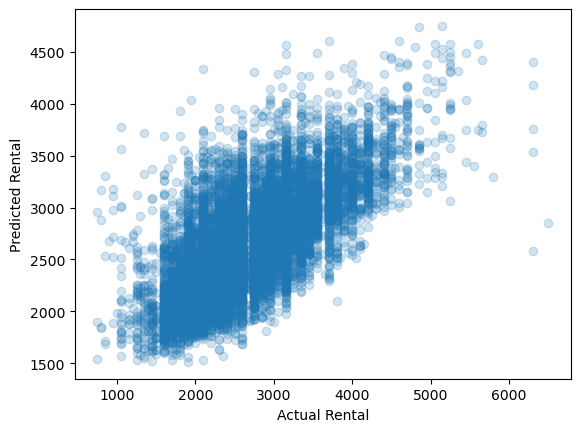

In [138]:
# actual vs predicted plot

plt.scatter(y_test, predicted_y, alpha=0.2)
plt.xlabel('Actual Rental')
plt.ylabel('Predicted Rental')
plt.show()

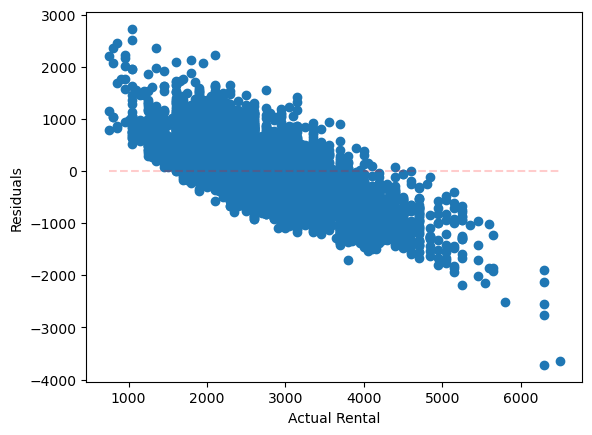

In [139]:
residuals = predicted_y - y_test
plt.scatter(y_test, residuals)
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max(), colors='red', linestyles='--', alpha=0.2)
plt.xlabel('Actual Rental')
plt.ylabel('Residuals')
plt.show()

**Kaggle Prediction**

In [140]:
# only run when running kaggle test
test_data = pd.read_csv('test.csv')
test_data = knn_preprocess_test_data(test_data)

test_x_cat = test_data[cat_features]
encoder = preprocessing.OneHotEncoder(sparse_output=False)
test_x_cat_transformed = encoder.fit_transform(test_x_cat)

test_x_num  = test_data[num_features].to_numpy()
test_x_concat = np.concatenate((test_x_num, test_x_cat_transformed), axis=1)

test_x_concat.shape

(30000, 37)

In [141]:
N = 33

scalar = preprocessing.MinMaxScaler(feature_range=(0, 1)).fit(x_concat)
neigh = KNeighborsRegressor(n_neighbors=N)
neigh.fit(scalar.transform(x_concat), y)
predicted_y = neigh.predict(scalar.transform(test_x_concat))

# Create a DataFrame with id and predictions
predictions_df = pd.DataFrame({
    'Id': np.arange(len(predicted_y)),
    'Predicted': predicted_y
})
# Save the DataFrame to a CSV file
predictions_df.to_csv('predictions.csv', index=False)

RMSE_test = 493.69348